In [37]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pylab as plt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from IPython.display import clear_output
from tensorflow.keras import layers

from keras.callbacks import Callback
from keras.models import Sequential
from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Convolution2D, BatchNormalization, MaxPool2D, Flatten, Dense, Dropout, Lambda
from keras.optimizers import *
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import to_categorical
from sklearn.model_selection import GridSearchCV
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from keras.regularizers import l2
from keras.layers import UpSampling2D
from keras.models import Sequential
from keras.layers import Conv2D,Dense,Flatten,Dropout,MaxPooling2D, GlobalAveragePooling1D, GlobalAveragePooling2D,Activation
import time
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras import regularizers
import nvidia_smi
from keras.callbacks import ReduceLROnPlateau



!pip install keras-lookahead
from keras_lookahead import Lookahead

#printing the tensorflow version
print(tf.__version__)

2.3.0


In [32]:
from keras.datasets import cifar10
(x_train,y_train),(x_test,y_test) = cifar10.load_data()
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

no_of_classes = len(np.unique(y_train))
print(no_of_classes)

#Data transformation 

x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255


#Split the training and validation data
X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)
10
(35000, 32, 32, 3)
(35000, 1)
(15000, 32, 32, 3)


In [33]:
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)

model = Sequential()
model.add(Conv2D(filters=32, kernel_size = 3, padding = 'same',kernel_initializer='he_uniform',activation = 'relu',input_shape=(32,32,3)))
model.add(Conv2D(filters=32, kernel_size = 3, padding = 'same',kernel_initializer='he_uniform',activation = 'relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64, kernel_size = 3, padding = 'same',kernel_initializer='he_uniform',activation = 'relu'))
model.add(Conv2D(filters=64, kernel_size = 3, padding = 'same',kernel_initializer='he_uniform',activation = 'relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=128, kernel_size = 3, padding = 'same',kernel_initializer='he_uniform',activation = 'relu'))
model.add(Conv2D(filters=128, kernel_size = 3, padding = 'same',kernel_initializer='he_uniform',activation = 'relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=256, kernel_size = 3, padding = 'same',kernel_initializer='he_uniform',activation = 'relu'))
model.add(Conv2D(filters=256, kernel_size = 3, padding = 'same',kernel_initializer='he_uniform',activation = 'relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())
model.add(Dense(512,activation='relu',kernel_initializer='he_uniform'))
model.add(Dropout(0.4))
model.add(Dense(10,activation='softmax'))
model.summary()



model.compile(optimizer = opt, loss ='sparse_categorical_crossentropy',metrics=['accuracy'])
print('compiled!')


history = model.fit(X_train,y_train, 
                    epochs = 20,
                    batch_size = 64 ,
                    #steps_per_epoch = steps,
          validation_data=(X_val,y_val),
          verbose=1)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 8, 8, 128)        

In [34]:
#Model evaluation 

score = model.evaluate(x_test,y_test, verbose =0)

score[1]

0.7282999753952026

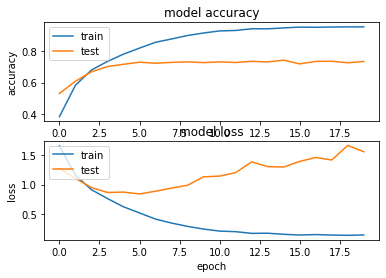

In [35]:
plt.figure(1)  
   
 # summarize history for accuracy  
  
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
   
 # summarize history for loss  
  
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()  

Transfer learning using Resnet50 

In [38]:
from keras.applications.resnet50 import ResNet50
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint


opt = SGD(lr=0.001, momentum=0.9, nesterov=True)
adam=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)


# add preprocessing layer to the front of resnet, 3 is the number of channels

conv_base = ResNet50(input_shape=(32,32,3), weights = None, include_top=False)
conv_base.summary()

# don't train existing weights
for layer in conv_base.layers:
  layer.trainable = True
  

model1 = Sequential()
model1.add(UpSampling2D(input_shape = (32,32,3))) #Upsampling is simply a way to magnify our image to make it bigger. 
#model1.add(BatchNormalization())
#model1.add(UpSampling2D())
#model1.add(BatchNormalization())
#model1.add(UpSampling2D())
#model1.add(BatchNormalization())
model1.add(conv_base)
model1.add(layers.Flatten())
#model1.add(Dense(4000,activation=('relu'),input_dim=512))
#model1.add(Dense(2000,activation=('relu'))) 
#model1.add(Dropout(0.4))
#model1.add(BatchNormalization())
model1.add(Dense(1000,activation=('relu'))) 
model1.add(Dropout(0.3))
model1.add(BatchNormalization())
model1.add(Dense(500,activation=('relu')))
model1.add(Dropout(.2))
model1.add(BatchNormalization())
model1.add(Dense(10,activation=('softmax')))


model1.summary()

model1.compile(
  loss='sparse_categorical_crossentropy',
  optimizer=adam,
  metrics=['accuracy']
)

lrr= ReduceLROnPlateau(
                       monitor='val_acc', #Metric to be measured
                       factor=.01, #Factor by which learning rate will be reduced
                       patience=3,  #No. of epochs after which if there is no improvement in the val_acc, the learning rate is reduced
                       min_lr=1e-5) #The minimum learning rate 

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [39]:
history1 = model1.fit(X_train,y_train,batch_size=64, 
                      steps_per_epoch = (len(X_train)/64),
                      validation_data = (X_val, y_val), 
                      epochs = 50, 
                      callbacks=[lrr])


Epoch 1/50
547/546 [==============================] - 53s 96ms/step - loss: 1.9293 - accuracy: 0.3249 - val_loss: 2.1937 - val_accuracy: 0.3213
Epoch 2/50
547/546 [==============================] - 51s 93ms/step - loss: 1.4150 - accuracy: 0.4990 - val_loss: 1.7506 - val_accuracy: 0.3909
Epoch 3/50
547/546 [==============================] - 51s 93ms/step - loss: 1.1629 - accuracy: 0.5943 - val_loss: 1.4315 - val_accuracy: 0.5070
Epoch 4/50
547/546 [==============================] - 51s 93ms/step - loss: 1.0193 - accuracy: 0.6457 - val_loss: 1.3630 - val_accuracy: 0.5253
Epoch 5/50
547/546 [==============================] - 51s 93ms/step - loss: 0.8777 - accuracy: 0.6937 - val_loss: 1.1110 - val_accuracy: 0.6112
Epoch 6/50
547/546 [==============================] - 51s 93ms/step - loss: 0.7492 - accuracy: 0.7428 - val_loss: 1.0992 - val_accuracy: 0.6353
Epoch 7/50
547/546 [==============================] - 51s 93ms/step - loss: 0.6781 - accuracy: 0.7674 - val_loss: 1.1505 - val_accuracy:

In [40]:
score_1 = model1.evaluate(x_test,y_test)
print('Test accuracy score is:', score_1[1])

313/313 [==============================] - 5s 16ms/step - loss: 1.3816 - accuracy: 0.7385
Test accuracy score is: 0.7384999990463257


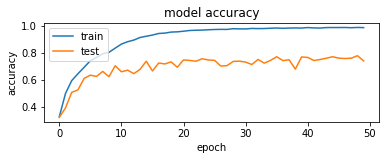

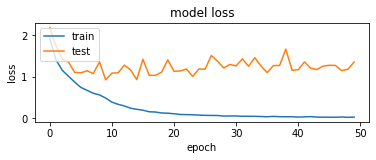

In [41]:
plt.figure(2)  
   
 # summarize history for accuracy  
  
plt.subplot(212)  
plt.plot(history1.history['accuracy'])  
plt.plot(history1.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()
 # summarize history for loss  
  
plt.subplot(212)  
plt.plot(history1.history['loss'])  
plt.plot(history1.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()  

Lookahead optimiser and step decay learning rate for fast training of Resnet50

In [42]:
#I have used a combination of lookahead optimiser along with the step decay learning rate
adam=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)
#initialize lookahead

#Defining the lookahead optimiser
lk = Lookahead(adam, sync_period=5, slow_step=0.5, name = 'Lookahead')



model1.compile(
  optimizer = lk.optimizer,
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy']
)


def step_decay(epoch):
    initAlpha = 0.01
    factor = 0.25
    dropEvery = 5
    
    alpha = initAlpha *(factor **np.floor((1 + epoch)/dropEvery))
    
    return float(alpha)



history = model1.fit(X_train,y_train,
                        batch_size=64,
                         steps_per_epoch = (len(X_train)/64),
                        validation_data=(X_val,y_val),
               callbacks=[LearningRateScheduler(step_decay)],
                        epochs=50)

Epoch 1/50
547/546 [==============================] - 52s 95ms/step - loss: 0.9304 - accuracy: 0.6973 - val_loss: 3.1175 - val_accuracy: 0.3765
Epoch 2/50
547/546 [==============================] - 50s 92ms/step - loss: 0.6007 - accuracy: 0.8035 - val_loss: 1.7292 - val_accuracy: 0.5469
Epoch 3/50
547/546 [==============================] - 50s 92ms/step - loss: 0.4885 - accuracy: 0.8387 - val_loss: 2.1671 - val_accuracy: 0.4989
Epoch 4/50
547/546 [==============================] - 51s 92ms/step - loss: 0.4144 - accuracy: 0.8627 - val_loss: 1.2283 - val_accuracy: 0.6544
Epoch 5/50
547/546 [==============================] - 50s 92ms/step - loss: 0.1260 - accuracy: 0.9594 - val_loss: 0.8437 - val_accuracy: 0.7761
Epoch 6/50
547/546 [==============================] - 50s 92ms/step - loss: 0.0401 - accuracy: 0.9874 - val_loss: 0.9937 - val_accuracy: 0.7889
Epoch 7/50
547/546 [==============================] - 50s 92ms/step - loss: 0.0406 - accuracy: 0.9874 - val_loss: 1.1016 - val_accuracy:

In [43]:
score_1 = model1.evaluate(x_test,y_test)
print('Test accuracy score is:', score_1[1])

313/313 [==============================] - 5s 16ms/step - loss: 1.3069 - accuracy: 0.8154
Test accuracy score is: 0.8154000043869019


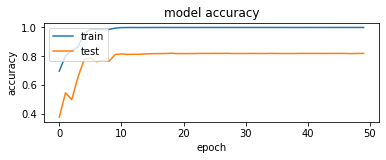

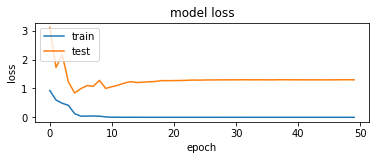

In [44]:
plt.figure(2)  
   
 # summarize history for accuracy  
  
plt.subplot(212)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()
 # summarize history for loss  
  
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()

Performance Comparison

I have used 50 epochs at both instances for Resnet50 model and Resnet50 model with lookahead optimiser 
(with adam as inner optimiser) together with step decay learning schedule, 

The total time consumed is measured in seconds, is same at both instances for 50 epochs(each epoch 51sec).
Based on the validation and accuracy graphs, it is clear, that the model converges at an early number of epochs when used with
 lookahead optimiser and step decay learning rate. 

with adam optimiser the model converges at 20 epochs at 74% test accuracy
whereas with lookahead (inner adam optimiser) + step learning rate decay, the model converges at 10 epochs at 82% test accuracy.
And from the accuracy curve at both instances, we can see that without the lookahead optimiser the validation curve is irregular whereas with lookahead the validation curve is more stable and flat.

and we are able to reach a high testing accuracy with lookahead optimiser.


Therefore we can conclude with the lookahead optimiser, we can achieve Faster convergence with little hyperparameter tuning on a
variety of datasets and models, big and small and that Lookahead improves the learning stability and lowers the variance of 
its inner optimizer with negligible computation and memory cost. We empirically demonstrate Lookahead can significantly 
improve the performance of SGD and Adam, even with their default hyperparameter settings.
